In [4]:
# Calculate different clustering methods
import networkx as nx
import pandas as pd
from networkx.algorithms.centrality import edge_betweenness_centrality

G = nx.read_graphml("network.graphml")
threshold = 0.29

# Create a filtered graph
filtered_edges = [(u, v, d) for u, v, d in G.edges(data=True) if d['weight'] > threshold]

network = nx.Graph()
network.add_edges_from(filtered_edges)

# Clustering analysis


In [5]:

from collections import defaultdict

# Get different clustering partitions
louvain_communities = nx.community.louvain_communities(network)
label_propagation = nx.community.label_propagation_communities(network)
greedy_modularity = nx.community.greedy_modularity_communities(network)
girvan_newman = nx.community.girvan_newman(network)
#edge_betweenness_centrality = nx.community.edge_betweenness_centrality(network, 3)



# Create a dictionary to store clusters and their nodes
clustering_results = {
    'louvain': list(louvain_communities),
    'label_propagation': list(label_propagation),
    'greedy_modularity': list(greedy_modularity),
    "greedy_modularity": list(greedy_modularity),
    #"girvan_newman": list(girvan_newman),
    #"edge_betweenness_centrality": edge_betweenness_centrality
}



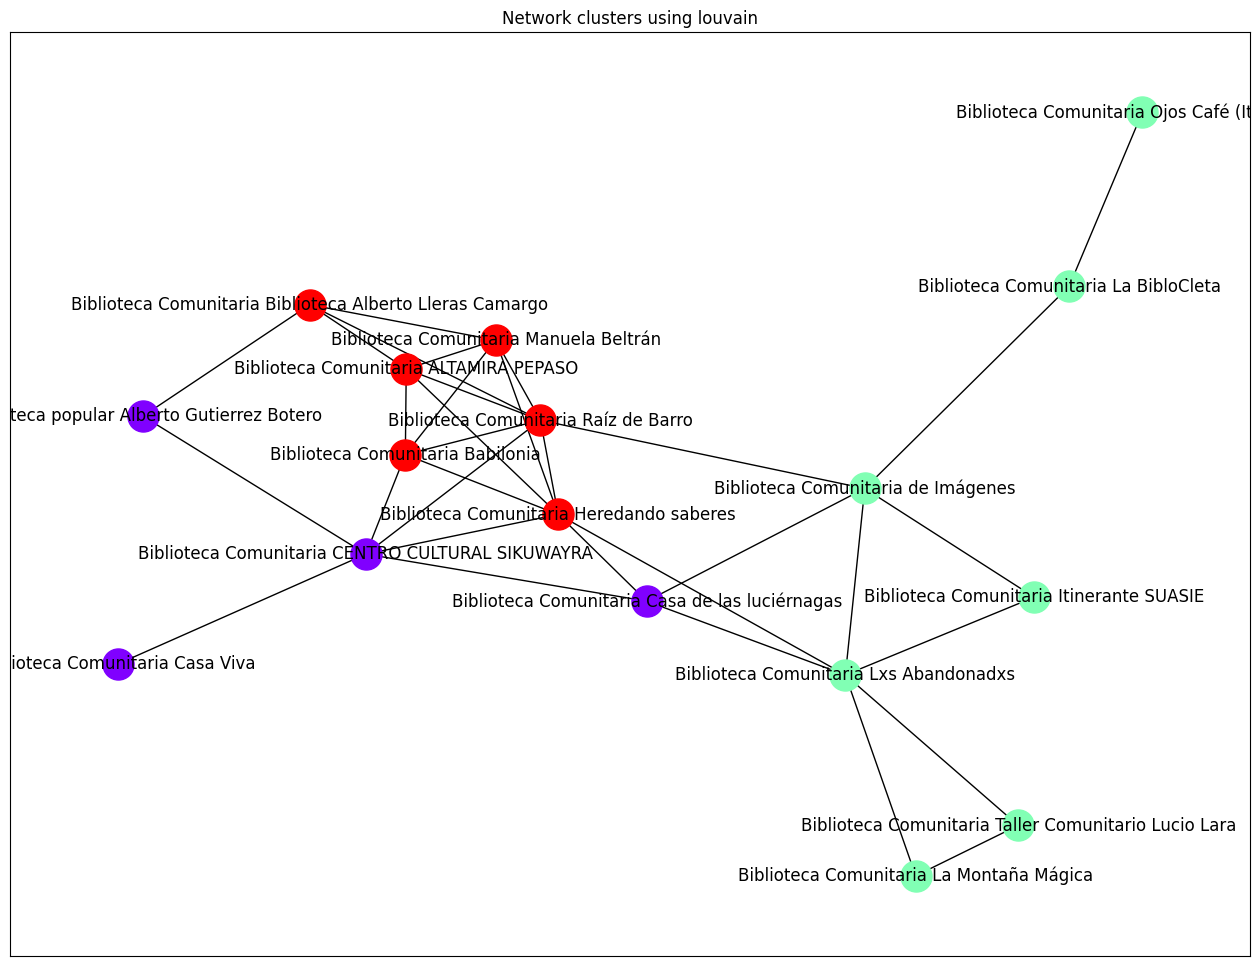

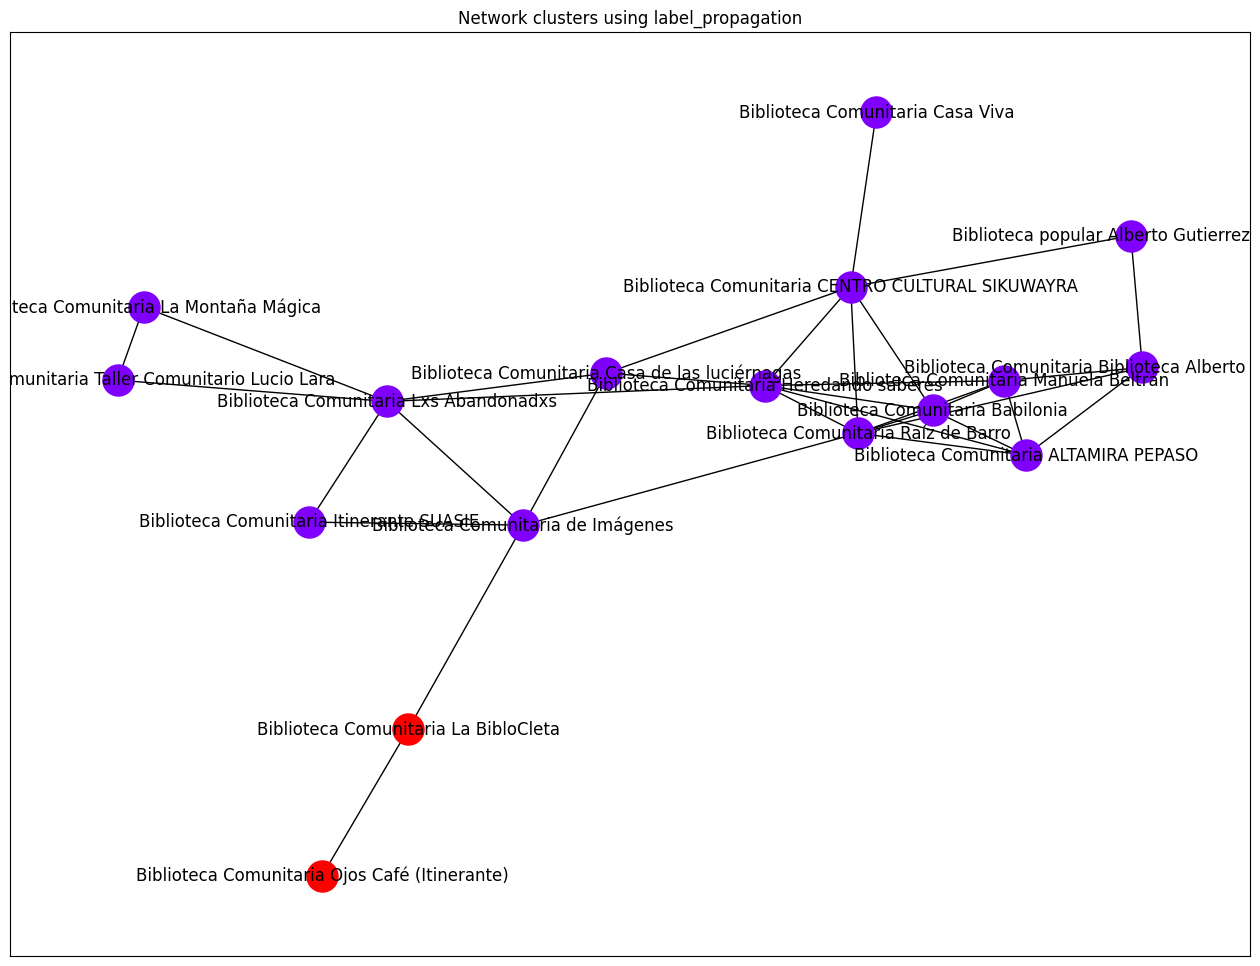

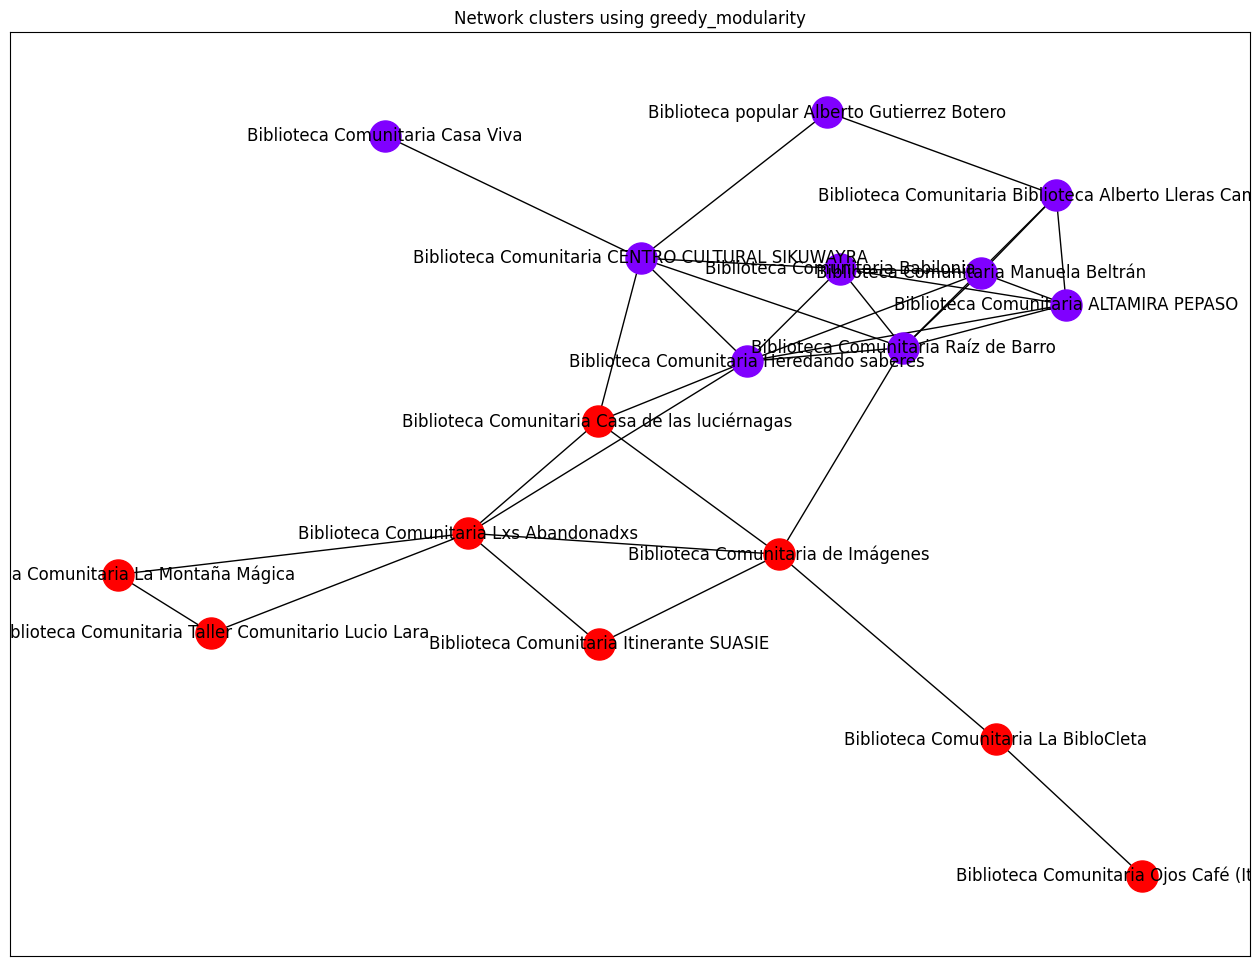

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def analyze_cluster_attributes(cluster, df):
    # Get subset of dataframe for cluster nodes
    cluster_df = df[df['BibliotecaNombre'].isin(cluster)]

    # Calculate statistics for numerical columns
    stats = cluster_df.describe()

    # Get mode for categorical columns
    categorical_stats = cluster_df.mode().iloc[0]

    return stats, categorical_stats


def draw_clustered_network(G, clusters, title):
    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(G)

    # Assign colors to clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)))

    for cluster, color in zip(clusters, colors):
        nx.draw_networkx_nodes(G, pos,
                               nodelist=cluster,
                               node_color=[color],
                               node_size=500)

    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)
    plt.title(title)
    plt.show()

df = pd.read_csv("..\output\\results.csv")

# Analyze each clustering method
cluster_analysis = defaultdict(dict)
for method, clusters in clustering_results.items():
    for i, cluster in enumerate(clusters):
        stats, cat_stats = analyze_cluster_attributes(cluster, df)
        cluster_analysis[method][f'cluster_{i}'] = {
            'nodes': list(cluster),
            'size': len(cluster),
            'numerical_stats': stats,
            'categorical_stats': cat_stats
        }


# Visualize each clustering method
for method, clusters in clustering_results.items():
    draw_clustered_network(network, clusters, f'Network clusters using {method}')


In [7]:
PROMPT = """You are tasked with writing a short analysis in markdown for each category based on survey data collected from a cluster of libraries. Your goal is to provide concise, objective insights for each analysis category in markdown.

First, here are the analysis categories and their descriptions:

<analysis_categories>
**Categoría de análisis: Nivel de avance en la sistematización de servicios bibliotecarios**

1. **Coordenada:** Sistemas de clasificación
   - **Descripción:** Sistemas usados para la organización de las colecciones
   - **Pregunta:** ¿Qué sistema de clasificación usa en la colección?

2. **Coordenada:** Nivel de detalle en la organización de la colección
   - **Descripción:** Nivel de organización de la colección en la biblioteca
   - **Pregunta:** ¿Cómo se identifica la ubicación de los libros en la colección?

3. **Coordenada:** Tiempo que le toma hallar un libro
   - **Descripción:** Tiempo que toma encontrar un libro en la biblioteca
   - **Pregunta:** ¿Cuánto tiempo en promedio tarda en encontrar un libro?

4. **Coordenada:** Sistema de registro de usuarios
   - **Descripción:** -
   - **Pregunta:** ¿Cuenta con sistema de registro de usuarios?

5. **Coordenada:** Reglamento de servicios
   - **Descripción:** -
   - **Pregunta:** ¿Existe un reglamento de servicios?

6. **Coordenada:** Sistematización en préstamo externo
   - **Descripción:** Nivel de sistematización en el proceso de préstamo de la biblioteca
   - **Pregunta:** ¿Cómo se gestionan los préstamos externos de la colección?

---

**Categoría de análisis: Caracterización de la colección**

1. **Coordenada:** Tipos de colecciones
   - **Descripción:** Tipos de colección disponibles en la biblioteca
   - **Pregunta:** -

2. **Coordenada:** Cantidad de material bibliográfico
   - **Descripción:** Número total de material bibliográfico en la colección
   - **Pregunta:** -

3. **Coordenada:** Percepción del estado físico de la colección
   - **Descripción:** Percepción del estado de conservación de la colección
   - **Pregunta:** ¿Cuál es su percepción general del estado de conservación de la colección?

4. **Coordenada:** Enfoques de las colecciones
   - **Descripción:** Calculada a partir de las respuestas múltiples de temas de las colecciones en las bibliotecas (si contesta un tema entonces es muy especializada, si contesta todos los temas no es especializada)
   - **Pregunta:** ¿Las colecciones en su biblioteca tienen un enfoque en particular?

5. **Coordenada:** Actividades de mediación con la colección
   - **Descripción:** -
   - **Pregunta:** ¿En cuáles actividades de mediación usas la colección?

6. **Coordenada:** Frecuencia actividades de mediación con la colección
   - **Descripción:** Frecuencia de mediación de lectura de las colecciones
   - **Pregunta:** ¿Con qué frecuencia se usa la colección en actividades de mediación?

7. **Coordenada:** Colecciones especiales
   - **Descripción:** Presencia de colecciones especializadas o poco comunes
   - **Pregunta:** ¿La biblioteca cuenta con colecciones de valor patrimonial?
</analysis_categories>

Now, here is the survey data collected from the libraries:

<survey_data>
{SURVEY_DATA}
</survey_data>

To complete this task, follow these steps:

1. Review the survey data carefully, focusing on the information relevant to each analysis category.

2. For each category, write a brief analysis (2-3 sentences) that summarizes the key findings or trends observed in the data.

3. Present your analysis in the following format:

<analysis>
<category>[Category name]</category>
<summary>[Your 2-3 sentence analysis here]</summary>
</analysis>

4. Write using makrdown to bold important concepts and put titles

5. Ten en cuenta qe un mejor resultado no significa que la biblioteca sea mejor, y puede que la biblioteca se enfonque en otras cosas. Por lo que no buscamos puntuarlas sino conocerlas y porderlas tipificar.

Remember to focus on providing insights that would be valuable for understanding the current state and potential areas for improvement in these libraries. Avoid making assumptions or drawing conclusions beyond what is directly supported by the data.

Present your complete analysis, covering all categories, in your response."""

In [8]:

# Analysis of Clusters
clustering_results
df_encuestas = pd.read_csv("../data/Formulario sobre coordenadas de análisis para el mapeo de colecciones en bibliotecas comunitarias de Bogotá (Respuestas) - Normalización Respuestas.csv")

# Explicación de los clusters
import openai

client = openai.OpenAI()


# Supongamos que ya tienes df_encuestas y df_categorias cargados

def construir_prompt(df_cluster):

    return PROMPT.format(SURVEY_DATA=df_cluster.to_string())


def analizar_cluster(cluster, df_surveys):
    # Filter the libraries in the cluster
    libraries = list(cluster)
    df_cluster = df_surveys[df_surveys['Nombre de la biblioteca comunitaria'].isin(libraries)]

    # Build the prompt
    prompt = construir_prompt(df_cluster)

    # Call the OpenAI API
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "Eres un analista de datos especializado en bibliotecas comunitarias."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.7,
    )

    # Extract the analysis
    analysis = response.choices[0].message.content.strip()
    return analysis


clusters = clustering_results
analisis = []
for algoritmo, lista_clusters in clusters.items():
    print(f"Análisis para el algoritmo: {algoritmo}\n")
    for idx, cluster in enumerate(lista_clusters):
        analisis.append(analizar_cluster(cluster, df_encuestas))
        print(f"Cluster {idx + 1}:\nProcesado\n")
    break

Análisis para el algoritmo: louvain

Cluster 1:
Procesado

Cluster 2:
Procesado

Cluster 3:
Procesado



In [9]:
from IPython.display import display, Markdown, Latex
string_analysis = ""
for i, text in enumerate(analisis):
    string_analysis += f"Cluster: {i+1}\n"
    string_analysis += f"Bibliotecas\n {lista_clusters[i]}\n"
    string_analysis += analisis[0] + "\n"

display(Markdown(string_analysis))

Cluster: 1
Bibliotecas
 {'Biblioteca Comunitaria CENTRO CULTURAL SIKUWAYRA', 'Biblioteca popular Alberto Gutierrez Botero', 'Biblioteca Comunitaria Casa Viva', 'Biblioteca Comunitaria Casa de las luciérnagas'}
```markdown
<analysis>
<category>**Nivel de avance en la sistematización de servicios bibliotecarios**</category>

**Coordenada: Sistemas de clasificación**
<summary>La mayoría de las bibliotecas utilizan sistemas de clasificación establecidos como el **sistema decimal de Dewey** y el **sistema de clasificación facetada**. Esto indica un alto grado de estandarización en la organización de las colecciones, lo cual facilita la ubicación y el acceso a los materiales.</summary>

**Coordenada: Nivel de detalle en la organización de la colección**
<summary>Las bibliotecas han implementado métodos de organización desde **secciones etiquetadas y señalizadas por temas** hasta **organización por categorías temáticas generales**. Este enfoque variado permite flexibilidad en la navegación de las colecciones, aunque la especificidad de las etiquetas puede mejorar la eficiencia de búsqueda.</summary>

**Coordenada: Tiempo que le toma hallar un libro**
<summary>En promedio, encontrar un libro toma alrededor de **5 minutos**, lo que sugiere que las bibliotecas tienen sistemas de organización bastante eficaces. Sin embargo, hay variabilidad, con algunas bibliotecas tardando hasta **20 minutos**, lo que podría indicar áreas para mejorar en términos de accesibilidad y señalización.</summary>

**Coordenada: Sistema de registro de usuarios**
<summary>La mayoría de las bibliotecas utilizan sistemas de registro de usuarios, principalmente a través de **software bibliográfico** o **hojas de cálculo**. Esto refleja un esfuerzo generalizado por mantener registros de usuarios, aunque la implementación de tecnología más avanzada podría optimizar estos procesos.</summary>

**Coordenada: Reglamento de servicios**
<summary>Las bibliotecas tienen reglamentos que varían en su estado de implementación, desde **borradores** hasta **reglamentos aprobados y difundidos**. Esto indica un compromiso con la formalización de las normas de uso, aunque existe espacio para mejorar la uniformidad y la claridad en su difusión.</summary>

**Coordenada: Sistematización en préstamo externo**
<summary>La gestión de préstamos externos se realiza principalmente a través de **registros en software bibliográfico** o **hojas de cálculo**, lo que muestra un nivel básico de sistematización. Sin embargo, la adopción de un sistema más integrado podría mejorar la eficiencia y el seguimiento de los préstamos.</summary>
</analysis>

<analysis>
<category>**Caracterización de la colección**</category>

**Coordenada: Tipos de colecciones**
<summary>Las bibliotecas ofrecen una variedad de tipos de colecciones, incluyendo **infantil, digital, y memoria local**, lo que sugiere un enfoque en diversidad y accesibilidad para diferentes públicos y necesidades culturales.</summary>

**Coordenada: Cantidad de material bibliográfico**
<summary>Aunque no se proporcionan cifras exactas, el porcentaje de colecciones ingresadas en catálogos varía significativamente, desde un **0%** hasta un **100%**, indicando diferentes niveles de avance en la digitalización y catalogación de las colecciones.</summary>

**Coordenada: Percepción del estado físico de la colección**
<summary>Las percepciones del estado físico de las colecciones son generalmente positivas, con la mayoría de materiales **bien conservados** aunque algunos requieren atención. Esto sugiere un mantenimiento adecuado, aunque es necesario el monitoreo continuo para prevenir el deterioro.</summary>

**Coordenada: Enfoques de las colecciones**
<summary>Las bibliotecas tienen enfoques temáticos variados, desde **educación infantil y adaptativa** hasta **memoria local y cultura**, reflejando un esfuerzo por atender las necesidades específicas de sus comunidades y fomentar la especialización temática.</summary>

**Coordenada: Actividades de mediación con la colección**
<summary>Las colecciones se utilizan ampliamente en actividades de mediación como **clubes de lectura** y **talleres de escritura**, lo que indica un uso activo y dinámico de los recursos bibliotecarios para promover la alfabetización y el compromiso comunitario.</summary>

**Coordenada: Frecuencia actividades de mediación con la colección**
<summary>Las actividades de mediación con la colección se realizan **siempre**, denotando un fuerte enfoque en el uso frecuente de los recursos para fomentar la interacción y el aprendizaje continuo entre los usuarios.</summary>

**Coordenada: Colecciones especiales**
<summary>Varias bibliotecas cuentan con **colecciones de valor patrimonial**, destacando su compromiso con la preservación de la memoria histórica y cultural, así como con la promoción del acceso a materiales únicos y especializados.</summary>
</analysis>
```
Cluster: 2
Bibliotecas
 {'Biblioteca Comunitaria Taller Comunitario Lucio Lara', 'Biblioteca Comunitaria La Montaña Mágica', 'Biblioteca Comunitaria Ojos Café (Itinerante)', 'Biblioteca Comunitaria La BibloCleta', 'Biblioteca Comunitaria Lxs Abandonadxs', 'Biblioteca Comunitaria Itinerante SUASIE', 'Biblioteca Comunitaria de Imágenes'}
```markdown
<analysis>
<category>**Nivel de avance en la sistematización de servicios bibliotecarios**</category>

**Coordenada: Sistemas de clasificación**
<summary>La mayoría de las bibliotecas utilizan sistemas de clasificación establecidos como el **sistema decimal de Dewey** y el **sistema de clasificación facetada**. Esto indica un alto grado de estandarización en la organización de las colecciones, lo cual facilita la ubicación y el acceso a los materiales.</summary>

**Coordenada: Nivel de detalle en la organización de la colección**
<summary>Las bibliotecas han implementado métodos de organización desde **secciones etiquetadas y señalizadas por temas** hasta **organización por categorías temáticas generales**. Este enfoque variado permite flexibilidad en la navegación de las colecciones, aunque la especificidad de las etiquetas puede mejorar la eficiencia de búsqueda.</summary>

**Coordenada: Tiempo que le toma hallar un libro**
<summary>En promedio, encontrar un libro toma alrededor de **5 minutos**, lo que sugiere que las bibliotecas tienen sistemas de organización bastante eficaces. Sin embargo, hay variabilidad, con algunas bibliotecas tardando hasta **20 minutos**, lo que podría indicar áreas para mejorar en términos de accesibilidad y señalización.</summary>

**Coordenada: Sistema de registro de usuarios**
<summary>La mayoría de las bibliotecas utilizan sistemas de registro de usuarios, principalmente a través de **software bibliográfico** o **hojas de cálculo**. Esto refleja un esfuerzo generalizado por mantener registros de usuarios, aunque la implementación de tecnología más avanzada podría optimizar estos procesos.</summary>

**Coordenada: Reglamento de servicios**
<summary>Las bibliotecas tienen reglamentos que varían en su estado de implementación, desde **borradores** hasta **reglamentos aprobados y difundidos**. Esto indica un compromiso con la formalización de las normas de uso, aunque existe espacio para mejorar la uniformidad y la claridad en su difusión.</summary>

**Coordenada: Sistematización en préstamo externo**
<summary>La gestión de préstamos externos se realiza principalmente a través de **registros en software bibliográfico** o **hojas de cálculo**, lo que muestra un nivel básico de sistematización. Sin embargo, la adopción de un sistema más integrado podría mejorar la eficiencia y el seguimiento de los préstamos.</summary>
</analysis>

<analysis>
<category>**Caracterización de la colección**</category>

**Coordenada: Tipos de colecciones**
<summary>Las bibliotecas ofrecen una variedad de tipos de colecciones, incluyendo **infantil, digital, y memoria local**, lo que sugiere un enfoque en diversidad y accesibilidad para diferentes públicos y necesidades culturales.</summary>

**Coordenada: Cantidad de material bibliográfico**
<summary>Aunque no se proporcionan cifras exactas, el porcentaje de colecciones ingresadas en catálogos varía significativamente, desde un **0%** hasta un **100%**, indicando diferentes niveles de avance en la digitalización y catalogación de las colecciones.</summary>

**Coordenada: Percepción del estado físico de la colección**
<summary>Las percepciones del estado físico de las colecciones son generalmente positivas, con la mayoría de materiales **bien conservados** aunque algunos requieren atención. Esto sugiere un mantenimiento adecuado, aunque es necesario el monitoreo continuo para prevenir el deterioro.</summary>

**Coordenada: Enfoques de las colecciones**
<summary>Las bibliotecas tienen enfoques temáticos variados, desde **educación infantil y adaptativa** hasta **memoria local y cultura**, reflejando un esfuerzo por atender las necesidades específicas de sus comunidades y fomentar la especialización temática.</summary>

**Coordenada: Actividades de mediación con la colección**
<summary>Las colecciones se utilizan ampliamente en actividades de mediación como **clubes de lectura** y **talleres de escritura**, lo que indica un uso activo y dinámico de los recursos bibliotecarios para promover la alfabetización y el compromiso comunitario.</summary>

**Coordenada: Frecuencia actividades de mediación con la colección**
<summary>Las actividades de mediación con la colección se realizan **siempre**, denotando un fuerte enfoque en el uso frecuente de los recursos para fomentar la interacción y el aprendizaje continuo entre los usuarios.</summary>

**Coordenada: Colecciones especiales**
<summary>Varias bibliotecas cuentan con **colecciones de valor patrimonial**, destacando su compromiso con la preservación de la memoria histórica y cultural, así como con la promoción del acceso a materiales únicos y especializados.</summary>
</analysis>
```
Cluster: 3
Bibliotecas
 {'Biblioteca Comunitaria Heredando saberes', 'Biblioteca Comunitaria ALTAMIRA PEPASO', 'Biblioteca Comunitaria Biblioteca Alberto Lleras Camargo', 'Biblioteca Comunitaria Raíz de Barro', 'Biblioteca Comunitaria Babilonia', 'Biblioteca Comunitaria Manuela Beltrán'}
```markdown
<analysis>
<category>**Nivel de avance en la sistematización de servicios bibliotecarios**</category>

**Coordenada: Sistemas de clasificación**
<summary>La mayoría de las bibliotecas utilizan sistemas de clasificación establecidos como el **sistema decimal de Dewey** y el **sistema de clasificación facetada**. Esto indica un alto grado de estandarización en la organización de las colecciones, lo cual facilita la ubicación y el acceso a los materiales.</summary>

**Coordenada: Nivel de detalle en la organización de la colección**
<summary>Las bibliotecas han implementado métodos de organización desde **secciones etiquetadas y señalizadas por temas** hasta **organización por categorías temáticas generales**. Este enfoque variado permite flexibilidad en la navegación de las colecciones, aunque la especificidad de las etiquetas puede mejorar la eficiencia de búsqueda.</summary>

**Coordenada: Tiempo que le toma hallar un libro**
<summary>En promedio, encontrar un libro toma alrededor de **5 minutos**, lo que sugiere que las bibliotecas tienen sistemas de organización bastante eficaces. Sin embargo, hay variabilidad, con algunas bibliotecas tardando hasta **20 minutos**, lo que podría indicar áreas para mejorar en términos de accesibilidad y señalización.</summary>

**Coordenada: Sistema de registro de usuarios**
<summary>La mayoría de las bibliotecas utilizan sistemas de registro de usuarios, principalmente a través de **software bibliográfico** o **hojas de cálculo**. Esto refleja un esfuerzo generalizado por mantener registros de usuarios, aunque la implementación de tecnología más avanzada podría optimizar estos procesos.</summary>

**Coordenada: Reglamento de servicios**
<summary>Las bibliotecas tienen reglamentos que varían en su estado de implementación, desde **borradores** hasta **reglamentos aprobados y difundidos**. Esto indica un compromiso con la formalización de las normas de uso, aunque existe espacio para mejorar la uniformidad y la claridad en su difusión.</summary>

**Coordenada: Sistematización en préstamo externo**
<summary>La gestión de préstamos externos se realiza principalmente a través de **registros en software bibliográfico** o **hojas de cálculo**, lo que muestra un nivel básico de sistematización. Sin embargo, la adopción de un sistema más integrado podría mejorar la eficiencia y el seguimiento de los préstamos.</summary>
</analysis>

<analysis>
<category>**Caracterización de la colección**</category>

**Coordenada: Tipos de colecciones**
<summary>Las bibliotecas ofrecen una variedad de tipos de colecciones, incluyendo **infantil, digital, y memoria local**, lo que sugiere un enfoque en diversidad y accesibilidad para diferentes públicos y necesidades culturales.</summary>

**Coordenada: Cantidad de material bibliográfico**
<summary>Aunque no se proporcionan cifras exactas, el porcentaje de colecciones ingresadas en catálogos varía significativamente, desde un **0%** hasta un **100%**, indicando diferentes niveles de avance en la digitalización y catalogación de las colecciones.</summary>

**Coordenada: Percepción del estado físico de la colección**
<summary>Las percepciones del estado físico de las colecciones son generalmente positivas, con la mayoría de materiales **bien conservados** aunque algunos requieren atención. Esto sugiere un mantenimiento adecuado, aunque es necesario el monitoreo continuo para prevenir el deterioro.</summary>

**Coordenada: Enfoques de las colecciones**
<summary>Las bibliotecas tienen enfoques temáticos variados, desde **educación infantil y adaptativa** hasta **memoria local y cultura**, reflejando un esfuerzo por atender las necesidades específicas de sus comunidades y fomentar la especialización temática.</summary>

**Coordenada: Actividades de mediación con la colección**
<summary>Las colecciones se utilizan ampliamente en actividades de mediación como **clubes de lectura** y **talleres de escritura**, lo que indica un uso activo y dinámico de los recursos bibliotecarios para promover la alfabetización y el compromiso comunitario.</summary>

**Coordenada: Frecuencia actividades de mediación con la colección**
<summary>Las actividades de mediación con la colección se realizan **siempre**, denotando un fuerte enfoque en el uso frecuente de los recursos para fomentar la interacción y el aprendizaje continuo entre los usuarios.</summary>

**Coordenada: Colecciones especiales**
<summary>Varias bibliotecas cuentan con **colecciones de valor patrimonial**, destacando su compromiso con la preservación de la memoria histórica y cultural, así como con la promoción del acceso a materiales únicos y especializados.</summary>
</analysis>
```


In [10]:
response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "Eres un poeta de las bibliotecas comunitarias"},
            {"role": "user", "content": "De acuerdo al analisis realizado vamos a darle un nombre a cada cluster de bibliotecas comunitarias que las represente.  " + string_analysis}
        ],
        temperature=0.7,
    )

display(Markdown(response.choices[0].message.content.strip()))

Para nombrar cada cluster de bibliotecas comunitarias, podemos inspirarnos en sus características compartidas, destacando su enfoque en la sistematización, la diversidad de colecciones y el compromiso con la comunidad. Aquí te presento propuestas para cada uno:

**Cluster 1:**
**"Navegantes del Conocimiento"**
Este nombre refleja el enfoque en la organización eficiente y la variedad temática de las colecciones, sugiriendo un viaje a través del conocimiento bien clasificado y accesible.

**Cluster 2:**
**"Guardianes de la Memoria"**
Este nombre destaca el compromiso de estas bibliotecas con la preservación del patrimonio y la memoria local, así como su enfoque itinerante y comunitario en la difusión del conocimiento.

**Cluster 3:**
**"Pioneros de la Lectura"**
Este nombre sugiere un enfoque innovador y adaptativo en la educación y la especialización temática, resaltando su papel en fomentar la lectura y la alfabetización en sus comunidades.

Cada nombre busca encapsular la esencia de las bibliotecas dentro de cada cluster, enfatizando sus fortalezas y contribuciones únicas al acceso al conocimiento y la cultura.